In [1]:
import sys
sys.path.append('../../')
import numpy as np
import pyopencl as cl
import pylab as plt
import time

In [2]:
from gunnar.kernels import MAT_KERNELS

In [3]:
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)
prg = cl.Program(ctx, MAT_KERNELS).build("-DTSM=128 -DTSN=128 -DTSK=16 -DWPTM=8 -DWPTN=8 -DTS=8")
8
A = np.random.randn(256, 256).astype(np.float32)
A_cl = cl.Buffer(ctx, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=A)
B = np.random.randn(256, 256).astype(np.float32)
B_cl = cl.Buffer(ctx, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=B)
C = np.empty((A.shape[0], B.shape[1]), dtype=np.float32)
C_cl = cl.Buffer(ctx, cl.mem_flags.WRITE_ONLY, size=C.nbytes)

assert A.shape[1] == B.shape[0]

M = A.shape[0]
M_cl = cl.Buffer(ctx, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=np.int32(M))
K = B.shape[0]
K_cl = cl.Buffer(ctx, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=np.int32(K))
N = B.shape[1]
N_cl = cl.Buffer(ctx, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=np.int32(N))

In [4]:
event = prg.myGEMM6(queue, (32, 32), (16, 16), M_cl, N_cl, K_cl, A_cl, B_cl, C_cl)
cl.wait_for_events([event,])

In [5]:
event = cl.enqueue_copy(queue, C, C_cl)
cl.wait_for_events([event,])

In [6]:
np.linalg.norm(C - np.matmul(B.T, A))

0.0

In [7]:
def get_time(size):
    ctx = cl.create_some_context()
    queue = cl.CommandQueue(ctx)
    prg = cl.Program(ctx, MAT_KERNELS).build("-DTSM=128 -DTSN=128 -DTSK=16 -DWPTM=8 -DWPTN=8 -DTS=8")

    A = np.random.randn(size, size).astype(np.float32)
    A_cl = cl.Buffer(ctx, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=A)
    B = np.random.randn(size, size).astype(np.float32)
    B_cl = cl.Buffer(ctx, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=B)
    C = np.empty((A.shape[0], B.shape[1]), dtype=np.float32)
    C_cl = cl.Buffer(ctx, cl.mem_flags.WRITE_ONLY, size=C.nbytes)

    assert A.shape[1] == B.shape[0]

    M = A.shape[0]
    M_cl = cl.Buffer(ctx, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=np.int32(M))
    K = B.shape[0]
    K_cl = cl.Buffer(ctx, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=np.int32(K))
    N = B.shape[1]
    N_cl = cl.Buffer(ctx, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=np.int32(N))
    
    t1 = time.time()
    CC = np.matmul(B.T, A)
#     CC= np.matmul(B, A)
    cpu_t = time.time() - t1
    
    t1 = time.time()
#     event = prg.myGEMM1(queue, (int(M), int(N)), (int(8), int(8)), M_cl, N_cl, K_cl, A_cl, B_cl, C_cl)
#     event = prg.myGEMM2(queue, (int(M), int(N)), (int(8), int(8)), M_cl, N_cl, K_cl, A_cl, B_cl, C_cl)
    event = prg.myGEMM6(queue, (int(M/8), int(N/8)), (int(128/8), int(128/8)), M_cl, N_cl, K_cl, A_cl, B_cl, C_cl)
    cl.wait_for_events([event,])
    cl_t = time.time() - t1
    
    event = cl.enqueue_copy(queue, C, C_cl)
    cl.wait_for_events([event,])
    
    score = np.linalg.norm(C - CC)
    
    return score, cpu_t, cl_t

In [8]:
from tqdm import tqdm
sizes = [128, 256, 512, 1024, 2048]
cputimes = list(); cltimes = list(); scores = list()
for s in tqdm(sizes):
    sc, ct, clt = get_time(s)
    cputimes.append(ct)
    cltimes.append(clt)
    scores.append(sc)

100%|██████████| 5/5 [00:01<00:00,  3.72it/s]


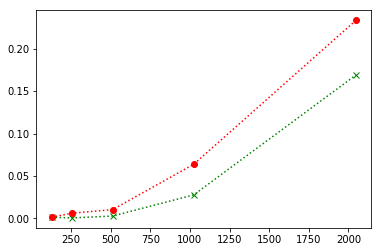

In [9]:
plt.plot(sizes, cputimes, 'gx:')
# plt.ylabel('cpu time')
# plt.twinx()
plt.plot(sizes, cltimes, 'ro:')
# plt.ylabel('cl time')
plt.show()

In [10]:
np.savez('k6.npz', time=cltimes, size=sizes, score=scores)

In [11]:
scores

[0.0, 0.0, 0.0044790357, 0.0188931, 0.07824701]